## Importing packages

In [1]:
import os
import re,string,unicodedata

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

import plotly.express as px
import plotly.graph_objects as go

import pickle
from joblib import dump, load

import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

In [140]:
# nltk.download("wordnet")

In [141]:
# nltk.download('omw-1.4')

## Loading dataset 

In [142]:
os.listdir("./datasets")

['IMDB Dataset.csv', 'tripadvisor.csv']

In [143]:
trip_advisor = pd.read_csv("./datasets/tripadvisor.csv")
trip_advisor.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [144]:
len(trip_advisor)

20491

In [145]:
trip_advisor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [146]:
trip_advisor = trip_advisor.rename(columns = {"Review": "review", "Rating": "rating"})

## Data Visualization

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

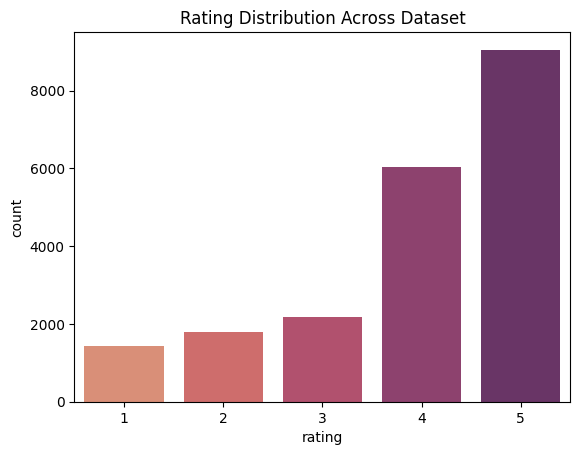

In [147]:
sns.countplot(data=trip_advisor, x='rating', palette='flare').set_title('Rating Distribution Across Dataset')

In [148]:
# length of word in a sentence 
trip_advisor['length'] = trip_advisor['review'].apply(len)
trip_advisor.head()

,review,rating,length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


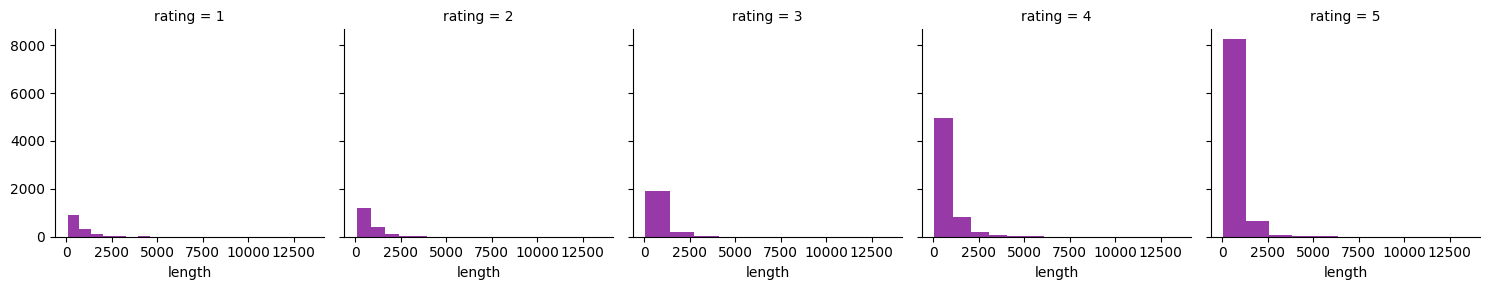

In [149]:
g = sns.FacetGrid(data=trip_advisor, col='rating')
g.map(plt.hist, 'length', color='#973aa8')

<AxesSubplot: xlabel='rating', ylabel='length'>

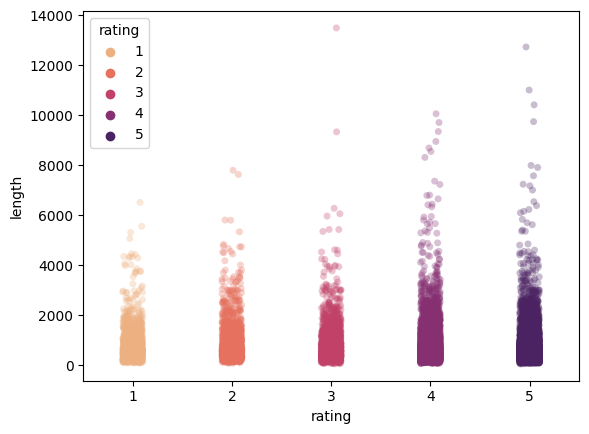

In [150]:
sns.stripplot(data=trip_advisor, x='rating', y='length', hue="rating", palette='flare', alpha=0.3)

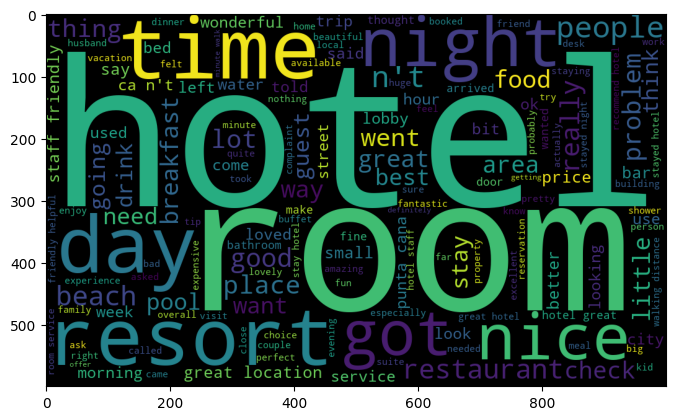

In [151]:
plt.figure(figsize=(8,8))
wc1 = WordCloud(max_words=200, min_font_size=10, 
                height=600,width=1000,background_color="black").generate(' '.join(trip_advisor['review']))

plt.imshow(wc1)

## Text Preprocessing

In [152]:
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Bad'

trip_advisor["sentiment"] = trip_advisor["rating"].apply(rating)

In [153]:
trip_advisor.head(20)

,review,rating,length,sentiment
0,nice hotel expensive parking got good deal sta...,4,593,Good
1,ok nothing special charge diamond member hilto...,2,1689,Bad
2,nice rooms not 4* experience hotel monaco seat...,3,1427,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,600,Good
4,"great stay great stay, went seahawk game aweso...",5,1281,Good
5,love monaco staff husband stayed hotel crazy w...,5,1002,Good
6,"cozy stay rainy city, husband spent 7 nights m...",5,748,Good
7,"excellent staff, housekeeping quality hotel ch...",4,597,Good
8,"hotel stayed hotel monaco cruise, rooms genero...",5,419,Good
9,excellent stayed hotel monaco past w/e delight...,5,271,Good


In [154]:
trip_advisor.head()

,review,rating,length,sentiment
0,nice hotel expensive parking got good deal sta...,4,593,Good
1,ok nothing special charge diamond member hilto...,2,1689,Bad
2,nice rooms not 4* experience hotel monaco seat...,3,1427,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,600,Good
4,"great stay great stay, went seahawk game aweso...",5,1281,Good


In [155]:
# Total word in dataset before cleaning
length = trip_advisor['length'].sum()
length

14853861

In [2]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    return clean_text

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def denoise_text(text):
    text_no_punc = cleaning(text)
    text_no_brackets = remove_between_square_brackets(text_no_punc)
    clean_text = remove_special_characters(text_no_brackets)
    return clean_text

In [157]:
trip_advisor['review']=trip_advisor['review'].apply(denoise_text)

In [158]:
trip_advisor.head()

,review,rating,length,sentiment
0,nice hotel expensive parking got good deal sta...,4,593,Good
1,ok nothing special charge diamond member hilto...,2,1689,Bad
2,nice rooms not 4 experience hotel monaco seatt...,3,1427,Neutral
3,unique great stay wonderful time hotel monaco ...,5,600,Good
4,great stay great stay went seahawk game awesom...,5,1281,Good


In [159]:
#Lemmetizing the text
def lemmatizer(text):
    word_lemmatizer = WordNetLemmatizer()
    text= ' '.join([word_lemmatizer.lemmatize(word, 'v') for word in text.split()])
    return text

In [160]:
print('Original:')
print(trip_advisor['review'][0])
print()

sentence = []
for word in trip_advisor['review'][0].split():
    word_lemmatizer = WordNetLemmatizer()
    sentence.append(word_lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews did valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe just noisy neighbors aveda bath products nice did not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience having pay 40 parking night  

Lemmatization:
nice hotel expensive park get good deal stay hotel anniversary arrive late even take advice previous review do valet park check quick easy little disappoint nonexistent view room room clean nice size bed comfortable wake stiff neck high pillow not soundproof like hear music room night morning loud bang doors open close hear people talk hallway maybe just noisy neighbor aveda bath products 

In [161]:
trip_advisor['review']=trip_advisor['review'].apply(lemmatizer)
trip_advisor["review"][0]

'nice hotel expensive park get good deal stay hotel anniversary arrive late even take advice previous review do valet park check quick easy little disappoint nonexistent view room room clean nice size bed comfortable wake stiff neck high pillow not soundproof like hear music room night morning loud bang doors open close hear people talk hallway maybe just noisy neighbor aveda bath products nice do not goldfish stay nice touch take advantage stay longer location great walk distance shop overall nice experience have pay 40 park night'

In [162]:
trip_advisor.head(10)

,review,rating,length,sentiment
0,nice hotel expensive park get good deal stay h...,4,593,Good
1,ok nothing special charge diamond member hilto...,2,1689,Bad
2,nice room not 4 experience hotel monaco seattl...,3,1427,Neutral
3,unique great stay wonderful time hotel monaco ...,5,600,Good
4,great stay great stay go seahawk game awesome ...,5,1281,Good
5,love monaco staff husband stay hotel crazy wee...,5,1002,Good
6,cozy stay rainy city husband spend 7 nights mo...,5,748,Good
7,excellent staff housekeep quality hotel chock ...,4,597,Good
8,hotel stay hotel monaco cruise room generous d...,5,419,Good
9,excellent stay hotel monaco past we delight re...,5,271,Good


In [163]:
# nltk.download('stopwords')

In [164]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [165]:
stop=set(stopwords.words('english'))
print(stop)

{'before', "weren't", 'on', 'if', 'between', 'there', 'hasn', 'theirs', 'can', 'shouldn', 'down', 'by', 'with', 'we', 'm', 'just', 'all', "couldn't", 'from', 'himself', "isn't", 'about', "aren't", 'he', 'why', 'so', 'to', 'this', 'who', 'under', 've', "hasn't", 'your', 'themselves', 'only', 'as', 'here', 'few', 'them', 'above', 'own', 'his', 't', 'these', 'some', 'shan', 'him', 'has', 'needn', 'do', 'been', 'her', "that'll", 'hers', 'out', 'mightn', 'me', "you've", 'be', 'through', 'what', 'off', "you're", 'does', "haven't", 'isn', 'while', "should've", 'during', 'both', 're', 'more', 'other', 'my', 'now', 'll', 'our', 'whom', 'up', 'is', 'will', 'but', 'mustn', 'not', 'am', "doesn't", 'hadn', "needn't", "mightn't", "wouldn't", 'too', 'myself', 'ours', "shouldn't", 'its', 'were', 'or', 'being', "you'll", 'haven', 'again', 'weren', 'ma', "she's", 'wouldn', 'very', 'won', 'having', 'in', 'until', "didn't", 'most', 'o', 'than', "you'd", 'for', 'd', 'where', 'at', "won't", 'and', 'they', '

In [166]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

trip_advisor['review']=trip_advisor['review'].apply(remove_stopwords)

In [167]:
trip_advisor["review"][0]

'nice hotel expensive park get good deal stay hotel anniversary arrive late even take advice previous review valet park check quick easy little disappoint nonexistent view room room clean nice size bed comfortable wake stiff neck high pillow soundproof like hear music room night morning loud bang doors open close hear people talk hallway maybe noisy neighbor aveda bath products nice goldfish stay nice touch take advantage stay longer location great walk distance shop overall nice experience pay 40 park night'

In [168]:
trip_advisor['length'] = trip_advisor['review'].apply(len)
trip_advisor.head()

,review,rating,length,sentiment
0,nice hotel expensive park get good deal stay h...,4,512,Good
1,ok nothing special charge diamond member hilto...,2,1538,Bad
2,nice room 4 experience hotel monaco seattle go...,3,1325,Neutral
3,unique great stay wonderful time hotel monaco ...,5,546,Good
4,great stay great stay go seahawk game awesome ...,5,1117,Good


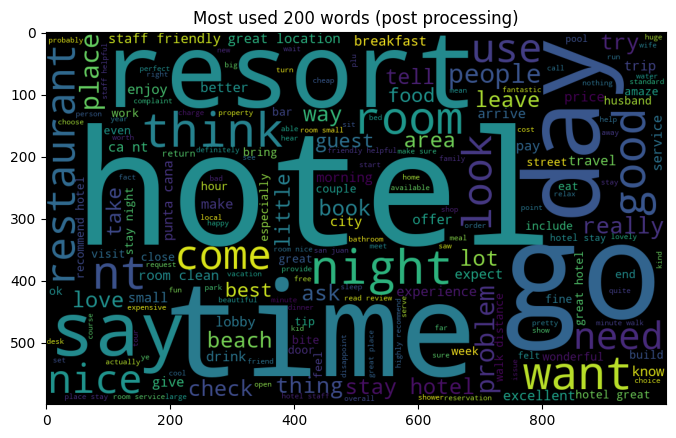

In [169]:
plt.figure(figsize=(8,8))
plt.title("Most used 200 words (post processing)")
wc1 = WordCloud(max_words=200, min_font_size=10, 
                height=600,width=1000,background_color="black").generate(' '.join(trip_advisor['review']))

plt.imshow(wc1)

## Data analysis

In [171]:
trip_good = trip_advisor[trip_advisor["sentiment"] == "Good"]
trip_neutral = trip_advisor[trip_advisor["sentiment"] == "Neutral"]
trip_bad = trip_advisor[trip_advisor["sentiment"] == "Bad"]

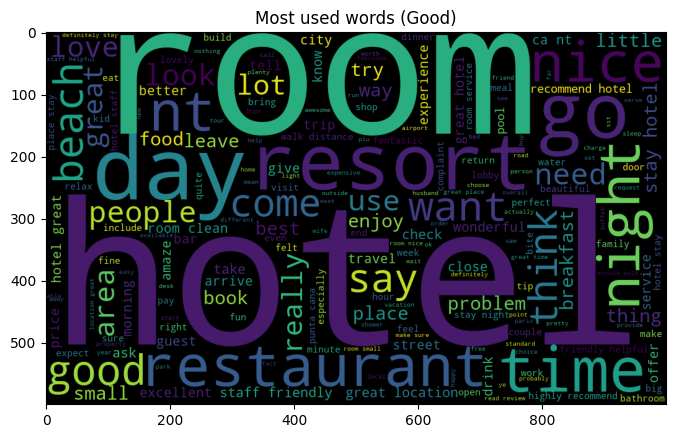

In [172]:
plt.figure(figsize=(8,8))
plt.title("Most used words (Good)")
wc1 = WordCloud(max_words=200, min_font_size=10, 
                height=600,width=1000,background_color="black").generate(' '.join(trip_good['review']))

plt.imshow(wc1)

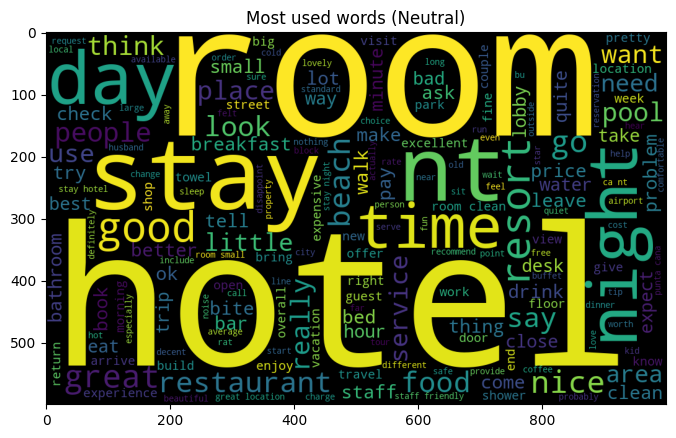

In [173]:
plt.figure(figsize=(8,8))
plt.title("Most used words (Neutral)")
wc1 = WordCloud(max_words=200, min_font_size=10, 
                height=600,width=1000,background_color="black").generate(' '.join(trip_neutral['review']))

plt.imshow(wc1)

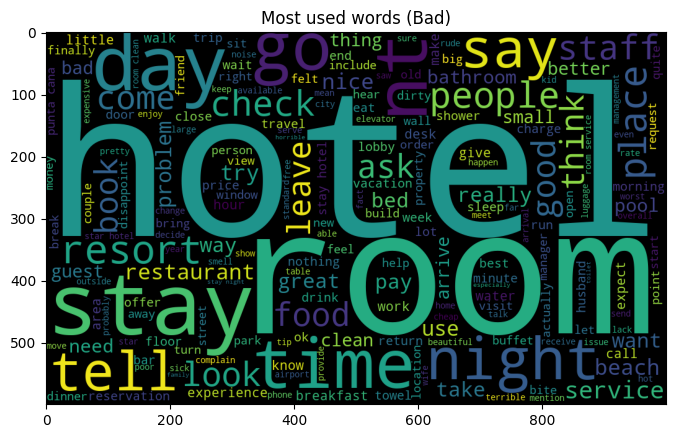

In [174]:
plt.figure(figsize=(8,8))
plt.title("Most used words (Bad)")
wc1 = WordCloud(max_words=200, min_font_size=10, 
                height=600,width=1000,background_color="black").generate(' '.join(trip_bad['review']))

plt.imshow(wc1)

#### **Analysis Results**
We have 20K Reviews in the hotel and the 3 sentiments
The percentage rating in the data set
> Good = 74% 


> Neutral = 10%


> Bad = 16%

**For good reviews, most used words:**
hotel - room - night - beach - restaurant and food and drink - bed - pool - locations - beautiful hotel - staff friendly - service - street

**For bad reviews, most used words:**
hotel - staff - beach - service - disk - stay - shower - room - place - door - check in - sleep - toilet - resort - water

## Building model with scikitlearn

In [176]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(trip_advisor, trip_advisor["rating"]):
    train_set = trip_advisor.loc[train_index]
    test_set = trip_advisor.loc[test_index]

In [177]:
test_set["rating"].value_counts() / len(test_set)

5    0.441815
4    0.294706
3    0.106611
2    0.087582
1    0.069285
Name: rating, dtype: float64

In [178]:
trip_advisor["rating"].value_counts() / len(trip_advisor)

5    0.441853
4    0.294715
3    0.106583
2    0.087502
1    0.069348
Name: rating, dtype: float64

In [179]:
for set_ in (train_set, test_set):
    set_.drop(["rating", "length"], axis=1, inplace=True)

train_set.head()

,review,sentiment
18017,excellent hotel great location stay casa campe...,Good
325,heavenly bed scam overall nice hotel excellent...,Good
19390,excellent choice room mate alicia modern small...,Good
5886,probably new yorks finest 4 star hotel return ...,Good
17248,stick sandals visit bahia principe punta cana ...,Bad


In [180]:
train_data = train_set.drop("sentiment", axis=1)
train_labels = train_set["sentiment"].copy()

In [181]:
train_data.head()

,review
18017,excellent hotel great location stay casa campe...
325,heavenly bed scam overall nice hotel excellent...
19390,excellent choice room mate alicia modern small...
5886,probably new yorks finest 4 star hotel return ...
17248,stick sandals visit bahia principe punta cana ...


In [182]:
train_labels

18017       Good
325         Good
19390       Good
5886        Good
17248        Bad
          ...   
5659        Good
10375       Good
11192        Bad
10159    Neutral
3323        Good
Name: sentiment, Length: 16392, dtype: object

In [183]:
test_data = test_set.drop("sentiment", axis=1)
test_labels = test_set["sentiment"].copy()

In [190]:
train_data.shape

(16392, 1)

In [192]:
tv = TfidfVectorizer()
train_tv_matrix = tv.fit_transform(train_data["review"])
test_tv_matrix = tv.transform(test_data["review"])

In [194]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [195]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tv_matrix, train_labels, scoring='accuracy',
                               cv=3).mean()
    accuracy.append(cross_val)

In [196]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.735359
1,RandomForestClassifier,0.772206
2,SVC,0.848524
3,LogisticRegression,0.852550
4,KNeighborsClassifier,0.782455
5,BernoulliNB,0.749329


In [197]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tv_matrix, train_labels)
pred = log.predict(test_tv_matrix)

In [198]:
# dump(log, "trip_advisor_model.joblib")

['trip_advisor_model.joblib']

In [200]:
# pickle.dump(tv, open('tv.pkl', 'wb'))

In [201]:
# pickle.dump(log, open('trip_advisor_model.pkl', 'wb'))

In [3]:
ml = pickle.load(open('trip_advisor_model.pkl','rb'))
tv = pickle.load(open('tv.pkl','rb'))

def ml_predict(text):
    clean_text = denoise_text(text)
    tv_matrix = tv.transform([clean_text])
    pred_proba = ml.predict_proba(tv_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]
    
    return pred, pred_proba[0][idx]

ml_predict('poor room service')

('Bad', 0.9640716823474939)

In [204]:
print(confusion_matrix(test_labels, pred))
print(classification_report(test_labels, pred))

[[ 487  121   35]
 [  28 2957   34]
 [  86  278   73]]
              precision    recall  f1-score   support

         Bad       0.81      0.76      0.78       643
        Good       0.88      0.98      0.93      3019
     Neutral       0.51      0.17      0.25       437

    accuracy                           0.86      4099
   macro avg       0.74      0.63      0.65      4099
weighted avg       0.83      0.86      0.83      4099



In [14]:
ml_predict("Room was not dirty")

('Bad', 0.9929266367691151)